# init

In [69]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch.nn.functional as F

from tqdm.notebook import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt
import random

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from nilearn import plotting
from torchsummary import summary
from torch.utils.data.dataset import random_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torchvision import transforms
from collections import Counter
import os

import pandas as pd
import scipy
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [4]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

device = 0

Torch version: 1.11.0+cu113
Using GPU


In [3]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 23836098560
free     : 5655101440
used     : 18180997120


In [10]:
labels = np.load("data/labels.npy")
tensors = np.load("data/tensors.npy")

tensors = tensors[:, 5:-5, 7:-5, 4:-11]
labels.shape, tensors.shape

((1113,), (1113, 48, 58, 43))

# models

In [11]:
class AE3b16_32ch32f(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder:
        
        self.block1 = nn.Sequential(
                nn.Conv3d(1, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16),
                nn.Conv3d(16, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16))

        self.block2 = nn.Sequential(
                nn.Conv3d(16, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.block3 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.pool1 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool2 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool3 = nn.MaxPool3d(2, 2, return_indices=True)
        
        self.feat = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.Conv3d(32, 32, 3, 1, 1),
                nn.Flatten())
        
        # decoder:
        
        self.unflat = nn.Unflatten(1, [32, 6, 7, 5])
        self.deblock1 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock2 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock3 = nn.Sequential(
                nn.ConvTranspose3d(32, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16),
                nn.ConvTranspose3d(16, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(16))
        
        self.unpool1 = nn.MaxUnpool3d(2, 2)
        self.unpool2 = nn.MaxUnpool3d(2, 2)
        self.unpool3 = nn.MaxUnpool3d(2, 2)
        
        self.reconstruct = nn.Sequential(
                nn.ConvTranspose3d(16, 16, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose3d(16, 1, 3, 1, 1))
        
        
    def encode(self, x):
        self.shape1 = x.shape
        x = self.block1(x)
        x, self.ind1 = self.pool1(x)
        
        self.shape2 = x.shape
        x = self.block2(x)
        x, self.ind2 = self.pool2(x)
        
        self.shape3 = x.shape
        x = self.block3(x)
        x, self.ind3 = self.pool3(x)
        
        x = self.feat(x)
        return x
    
    def decode(self, x):
        x = self.unflat(x)
        
        x = self.deblock1(x)
        x = self.unpool1(x, self.ind3, self.shape3)
        
        x = self.deblock2(x)
        x = self.unpool2(x, self.ind2, self.shape2)
        
        x = self.deblock3(x)
        x = self.unpool3(x, self.ind1, self.shape1)
        
        x = self.reconstruct(x)
        return x
    
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [12]:
class AE3b32ch16f(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder:
        
        self.block1 = nn.Sequential(
                nn.Conv3d(1, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))

        self.block2 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.block3 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.pool1 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool2 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool3 = nn.MaxPool3d(2, 2, return_indices=True)
        
        self.feat = nn.Sequential(
                nn.Conv3d(32, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.Conv3d(16, 16, 3, 1, 1),
                nn.Flatten())
        
        # decoder:
        
        self.unflat = nn.Unflatten(1, [16, 6, 7, 5])
        self.deblock1 = nn.Sequential(
                nn.ConvTranspose3d(16, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock2 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock3 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.unpool1 = nn.MaxUnpool3d(2, 2)
        self.unpool2 = nn.MaxUnpool3d(2, 2)
        self.unpool3 = nn.MaxUnpool3d(2, 2)
        
        self.reconstruct = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose3d(32, 1, 3, 1, 1))
        
        
    def encode(self, x):
        self.shape1 = x.shape
        x = self.block1(x)
        x, self.ind1 = self.pool1(x)
        
        self.shape2 = x.shape
        x = self.block2(x)
        x, self.ind2 = self.pool2(x)
        
        self.shape3 = x.shape
        x = self.block3(x)
        x, self.ind3 = self.pool3(x)
        
        x = self.feat(x)
        return x
    
    def decode(self, x):
        x = self.unflat(x)
        
        x = self.deblock1(x)
        x = self.unpool1(x, self.ind3, self.shape3)
        
        x = self.deblock2(x)
        x = self.unpool2(x, self.ind2, self.shape2)
        
        x = self.deblock3(x)
        x = self.unpool3(x, self.ind1, self.shape1)
        
        x = self.reconstruct(x)
        return x
    
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [13]:
class VAE3b32ch16f(nn.Module):
    def __init__(self, latent_shape=3360):
        super().__init__()
        
        # encoder:
        
        self.block1 = nn.Sequential(
                nn.Conv3d(1, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))

        self.block2 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.block3 = nn.Sequential(
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.Conv3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.pool1 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool2 = nn.MaxPool3d(2, 2, return_indices=True)
        self.pool3 = nn.MaxPool3d(2, 2, return_indices=True)
        
        self.feat = nn.Sequential(
                nn.Conv3d(32, 16, 3, 1, 1), 
                nn.ReLU(),
                nn.Conv3d(16, 16, 3, 1, 1),
                nn.Flatten())

        # distrib
        
        self.enc_mu = nn.Linear(3360, latent_shape)
        self.enc_sig = nn.Linear(3360, latent_shape)
        
        # decoder:
        
        self.unflat = nn.Sequential(
                nn.Linear(latent_shape, 3360),
                nn.Unflatten(1, [16, 6, 7, 5]))
        
        self.deblock1 = nn.Sequential(
                nn.ConvTranspose3d(16, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock2 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.deblock3 = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32),
                nn.ConvTranspose3d(32, 32, 3, 1, 1), 
                nn.ReLU(),
                nn.BatchNorm3d(32))
        
        self.unpool1 = nn.MaxUnpool3d(2, 2)
        self.unpool2 = nn.MaxUnpool3d(2, 2)
        self.unpool3 = nn.MaxUnpool3d(2, 2)
        
        self.reconstruct = nn.Sequential(
                nn.ConvTranspose3d(32, 32, 3, 1, 1),
                nn.ReLU(),
                nn.ConvTranspose3d(32, 1, 3, 1, 1))
        
        
    def encode(self, x):
        self.shape1 = x.shape
        x = self.block1(x)
        x, self.ind1 = self.pool1(x)
        
        self.shape2 = x.shape
        x = self.block2(x)
        x, self.ind2 = self.pool2(x)
        
        self.shape3 = x.shape
        x = self.block3(x)
        x, self.ind3 = self.pool3(x)
        
        x = self.feat(x)
        mu, sig = self.enc_mu(x), self.enc_sig(x)
        return mu, sig
    
    def decode(self, mu, sig):
        # temp block
#         std = torch.exp(sig / 2)
#         q = torch.distributions.Normal(mu, std)
#         x = q.rsample()
        # temp block
        epsilon = torch.randn(mu.shape).to(device=device)
        x = mu + epsilon * sig
        
        x = self.unflat(x)
        
        x = self.deblock1(x)
        x = self.unpool1(x, self.ind3, self.shape3)
        
        x = self.deblock2(x)
        x = self.unpool2(x, self.ind2, self.shape2)
        
        x = self.deblock3(x)
        x = self.unpool3(x, self.ind1, self.shape1)
        
        x = self.reconstruct(x)
        return x
    
        
    def forward(self, x):
        mu, sig = self.encode(x)
        x = self.decode(mu, sig)
        return mu, sig, x

# classification accuracy

In [8]:
def classification_accuracy(data, labels, model, vae=False):
    with torch.no_grad():
        model.eval()
        vectors = model.encode(torch.Tensor(data[:, None]))
        if vae:
            eps = torch.randn(vectors[0].shape)
            vectors = vectors[0].cpu() + eps * vectors[1].cpu()
        
    cv = KFold(n_splits=5)
    accs1 = []
    accs2 = []

    for tr_i, te_i in tqdm(cv.split(vectors)):
        regr = LogisticRegression(max_iter=500, ).fit(vectors[tr_i], labels[tr_i])
        rfor = RandomForestClassifier(n_estimators=300, n_jobs=-1, ).fit(vectors[tr_i], labels[tr_i])
        pred = regr.predict(vectors[te_i])
        accs1.append(accuracy_score(labels[te_i], pred))
        pred = rfor.predict(vectors[te_i])
        accs2.append(accuracy_score(labels[te_i], pred))
    
    return accs1, accs2, vectors

In [10]:
# ae_exp1_norm_crit/full_16-32x32_crit_46

# ae_exp2/full_32x16_crit_40

### AE3b16-32ch32f

In [38]:
model = AE3b16_32ch32f()
model.load_state_dict(torch.load("saves/ae_exp1_norm_crit/full_16-32x32_crit_46", map_location='cpu'))
model.eval()

accs1, accs2, mod3vectors = classification_accuracy(torch.Tensor(tensors), labels, model)

In [40]:
print(f'logreg:\n   mean = {np.mean(accs1)}\n   cv:\n{accs1}')
print(f'random forest:\n   mean = {np.mean(accs2)}\n   cv:\n{accs2}')

logreg:
   mean = 0.9092231244697612
   cv:
[0.9103139013452914, 0.9192825112107623, 0.9327354260089686, 0.9099099099099099, 0.8738738738738738]
random forest:
   mean = 0.890376924009211
   cv:
[0.8968609865470852, 0.8923766816143498, 0.8923766816143498, 0.8918918918918919, 0.8783783783783784]


### AE3b32ch16f

In [47]:
model = AE3b32ch16f()
model.load_state_dict(torch.load("saves/ae_exp2/full_32x16_crit_40", map_location='cpu'))
model.eval()

accs1, accs2, mod3vectors = classification_accuracy(torch.Tensor(tensors), labels, model)

In [48]:
print(f'logreg:\n   mean = {np.mean(accs1)}\n   cv:\n{accs1}')
print(f'random forest:\n   mean = {np.mean(accs2)}\n   cv:\n{accs2}')

logreg:
   mean = 0.902015917262554
   cv:
[0.9192825112107623, 0.905829596412556, 0.9372197309417041, 0.8603603603603603, 0.8873873873873874]
random forest:
   mean = 0.8957621298428473
   cv:
[0.8968609865470852, 0.8968609865470852, 0.9103139013452914, 0.9054054054054054, 0.8693693693693694]


### VAE3b32ch16f

In [27]:
model = VAE3b32ch16f()
model.load_state_dict(torch.load("vae_exp1/vae3b32ch16f_crit_46", map_location='cpu'))
model.eval()

accs1, accs2 = classification_accuracy(tensors, labels, model, vae=True)

In [29]:
print(f'logreg:\n   mean = {np.mean(accs1)}\n   cv:\n{accs1}')
print(f'random forest:\n   mean = {np.mean(accs2)}\n   cv:\n{accs2}')

logreg:
   mean = 0.7358259604896377
   cv:
[0.7757847533632287, 0.7174887892376681, 0.7399103139013453, 0.7432432432432432, 0.7027027027027027]
random forest:
   mean = 0.6118571486284491
   cv:
[0.6547085201793722, 0.57847533632287, 0.6053811659192825, 0.6261261261261262, 0.5945945945945946]


### VAE3b32ch16f - normalized data

In [14]:
model = VAE3b32ch16f()
model.load_state_dict(torch.load("vae_exp3/vae3b32ch16f_crit_32", map_location='cpu'))
model.eval()
norm = transforms.Normalize(mean=267.57535, std=350.7396)

accs = classification_accuracy(norm(torch.Tensor(tensors)), labels, model, vae=True)

In [15]:
np.mean(accs), accs

(0.4995273300206035,
 [0.5067264573991032,
  0.5201793721973094,
  0.4977578475336323,
  0.5,
  0.47297297297297297])

### VAE3b32ch16f - with hyperparams

In [15]:
model = VAE3b32ch16f()
model.load_state_dict(torch.load("saves/vae_exp4/vae3b32ch16f_crit_87", map_location='cpu'))
model.eval()
norm = transforms.Normalize(mean=267.57535, std=350.7396)

accs1, accs2, mod1vectors = classification_accuracy(norm(torch.Tensor(tensors)), labels, model, vae=True)

In [16]:
print(f'logreg:\n   mean = {np.mean(accs1)}\n   cv:\n{accs1}')
print(f'random forest:\n   mean = {np.mean(accs2)}\n   cv:\n{accs2}')

logreg:
   mean = 0.5264654789318466
   cv:
[0.5336322869955157, 0.5829596412556054, 0.5067264573991032, 0.5, 0.509009009009009]
random forest:
   mean = 0.5282834403910638
   cv:
[0.5426008968609866, 0.5515695067264574, 0.5112107623318386, 0.5180180180180181, 0.5180180180180181]


### AE3b32ch16f - normalized data

In [18]:
model = AE3b32ch16f()
model.load_state_dict(torch.load("saves/ae_exp3.5norm/AE3b32ch32f_crit_41", map_location='cpu'))
model.eval()
norm = transforms.Normalize(mean=267.57535, std=350.7396)

accs1, accs2, mod2vectors = classification_accuracy(norm(torch.Tensor(tensors)), labels, model)

In [19]:
print(f'logreg:\n   mean = {np.mean(accs1)}\n   cv:\n{accs1}')
print(f'random forest:\n   mean = {np.mean(accs2)}\n   cv:\n{accs2}')

logreg:
   mean = 0.9343837110653255
   cv:
[0.9372197309417041, 0.9327354260089686, 0.9641255605381166, 0.9234234234234234, 0.9144144144144144]
random forest:
   mean = 0.8930675069688523
   cv:
[0.8968609865470852, 0.8923766816143498, 0.905829596412556, 0.9009009009009009, 0.8693693693693694]


In [52]:
pvals = scipy.stats.ttest_ind(mod1vectors.T, mod2vectors.T, equal_var=False)

In [53]:
print(pvals.pvalue, pvals.pvalue.max(), pvals.pvalue.mean(), sep='\n')

[5.0915815e-02 9.3560637e-04 5.7974835e-03 ... 8.3938605e-05 9.5290568e-04
 5.0369922e-02]
0.96233094
0.022144146


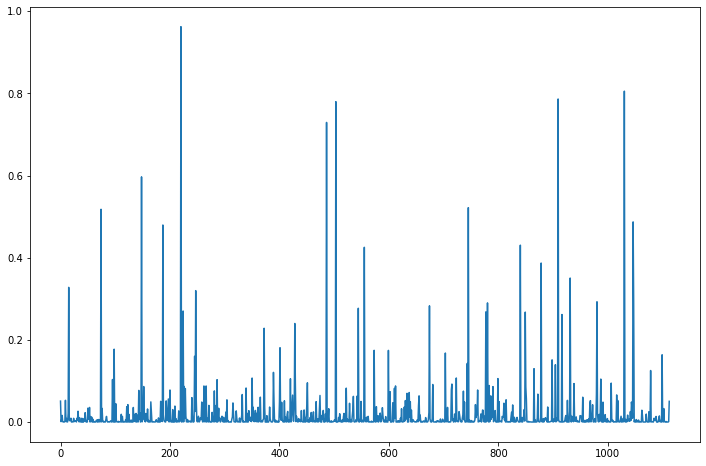

In [54]:
plt.figure(figsize=(12,8))
plt.plot(pvals.pvalue)

[3.8717988e-14 8.9827195e-09 2.3609201e-12 ... 6.4014516e-13 6.3545490e-13
 3.1635983e-10]
0.73417395
0.009860419


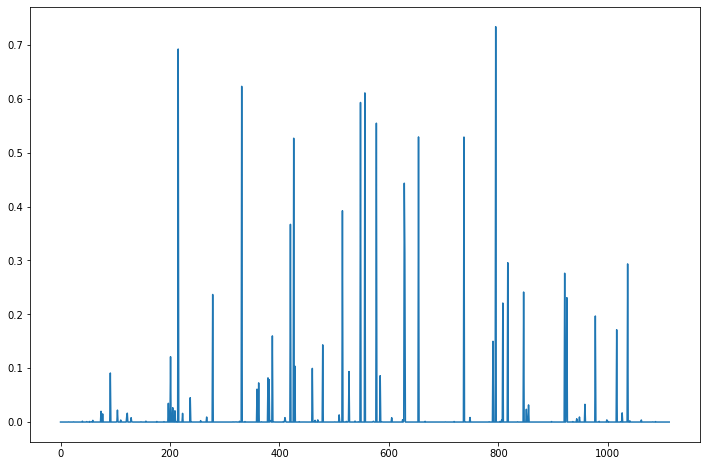

In [51]:
pvals = scipy.stats.ttest_ind(mod3vectors.T, mod2vectors.T, equal_var=False)
print(pvals.pvalue, pvals.pvalue.max(), pvals.pvalue.mean(), sep='\n')
plt.figure(figsize=(12,8))
plt.plot(pvals.pvalue)

In [50]:
mod3vectors.shape, mod2vectors.shape

(torch.Size([1113, 3360]), torch.Size([1113, 3360]))

# KL - train (failed)

In [12]:
def create_stop_crit(buff):
    
    def stop_crit(loss):
        if len(loss) < buff:
            return False
        return np.mean(loss[-buff:]) < loss[-1]
    
    return stop_crit

In [8]:
def get_bars(arr):
    n = 250
    ret = np.zeros(n)
    
    for i in arr:
        ret[i] += 1

    return ret


def KL_train(model, loader, valloader, optimizer, epochs=500, start_e=0, save_n=25,
          stop=(lambda loss:  False), exp_name='undef_exp', folder='unsorted'):

    recloss = []
    vals = []
    if folder not in os.listdir():
        os.mkdir(folder)
    for e in range(start_e, epochs):
        running_loss = 0
        model.train()
        for i, (X, y) in tqdm(enumerate(loader)):
            X = X.cuda()
            y = y.cuda()
            outs = model(X)
            
            with torch.no_grad():
                Xvect = ((X.reshape(64, -1) + 0.7629) / (3.8590 + 0.7629) * 249).int()
                bars_before = np.apply_along_axis(get_bars, 1, Xvect.cpu().numpy())
                Xvect = ((outs.reshape(64, -1) + 0.7629) / (3.8590 + 0.7629) * 249).int()
                bars_after = np.apply_along_axis(get_bars, 1, Xvect.cpu().numpy())
            
            loss = F.mse_loss(torch.Tensor(bars_before).cuda(), torch.Tensor(bars_after).cuda())
            running_loss += loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        recloss.append(running_loss.item() / len(loader))
        
        model.eval()
        valloss = 0
        with torch.no_grad():
            for X, y in valloader:
                X = X.cuda()
                outs = model(X)
                valloss += criterion(outs, X)

        vals.append(valloss.item() / len(valloader))
        
        # visualize
        clear_output(True)
        print('Epoch', e)
        print('Reconstruction Loss: ', recloss[-1])
        print('Validation Loss: ', vals[-1])
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(range(start_e, e + 1), recloss)
        ax[1].plot(range(start_e, e + 1), vals)
        ax[0].set_title('Reconstruction loss')
        ax[1].set_title('Validation Loss')

        t1 = nib.Nifti1Image(X[0][0].detach().cpu().numpy(), np.diag([1, 1, 1, 1]))
        t2 = nib.Nifti1Image(outs[0][0].detach().cpu().numpy(), np.diag([1, 1, 1, 1]))
        f = plt.figure(figsize=(10, 6))
        ax = plt.subplot(2, 1, 1)
        plotting.plot_img(t1, [s / 2 for s in t1.shape], title="Truth", axes=ax)
        ax = plt.subplot(2, 1, 2)
        plotting.plot_img(t2, [s / 2 for s in t2.shape], title="Reconstructed", axes=ax)
        plt.show()

        if e % save_n == 0:
            torch.save(model.state_dict(), f'{folder + "/" + exp_name + "_"}{start_e + e}')

        if stop(vals):
            torch.save(model.state_dict(), f'{folder + "/" + exp_name + "_crit_"}{start_e + e}')
            return

### AE3b32ch16f

In [9]:
tensors.mean(), tensors.std()

(267.57535, 350.7396)

In [10]:
norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))

In [11]:
model = AE3b32ch16f().cuda()
# model.load_state_dict(torch.load(base_path + 'ae/const_32x64_425'))
trains, valss = random_split(ds, [int(len(ds) * 0.8), len(ds) - int(len(ds) * 0.8)])
trainloader = DataLoader(trains, batch_size=64)
valloader = DataLoader(valss, batch_size=32)
optimizer = optim.Adam(model.parameters(),  lr = 0.01, betas=(0.9, 0.999))
stop_crit = create_stop_crit(buff=10)

KL_train(model, trainloader, valloader, optimizer, stop=stop_crit, start_e=0,
      exp_name='full_32x16', folder='metrics-KL')

/home/kondrateva/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:847: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool3d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [95]:
%%time
def get_bars(arr):
    n = 250
    ret = np.zeros(n)
    
    for i in arr:
        ret[i] += 1

    return ret

loader  = DataLoader(ds, batch_size=64)
X, y = next(iter(loader))
Xvect = ((X.reshape(64, -1) + 0.7629) / (3.8590 + 0.7629) * 249).numpy().astype(int)
ins = np.apply_along_axis(get_bars, 1, Xvect)

X, y = next(iter(loader))
Xvect = ((X.reshape(64, -1) + 0.7629) / (3.8590 + 0.7629) * 249).numpy().astype(int)
outs = np.apply_along_axis(get_bars, 1, Xvect)

CPU times: user 19.1 s, sys: 928 ms, total: 20 s
Wall time: 13.2 s


# EMD (already trained)

In [12]:
def EMD(loader, model, bars=500, vae=False):
    def get_bars(arr):
        hist, ind = np.histogram(arr, bins=bars)
        return ind
    
    with torch.no_grad():
        model.eval()
        total_kl = 0
        
        for X, y in tqdm(loader):
            X = X.cuda()
            outs = model(X)
            if vae:
                outs = outs[-1]
            
            
            Xvect = X.reshape(X.shape[0], -1)
            bars_before = np.apply_along_axis(get_bars, 1, Xvect.cpu())
            Xvect = outs.reshape(outs.shape[0], -1)
            bars_after = np.apply_along_axis(get_bars, 1, Xvect.cpu())
            
            kl = F.l1_loss(torch.Tensor(bars_before).cuda(), torch.Tensor(bars_after).cuda())
            total_kl += kl
    
    return total_kl.item()

In [23]:
tensors.min(), tensors.max()

(0.0, 1621.0754)

### AE3b16_32ch32f

In [92]:
model = AE3b16_32ch32f().cuda()
model.load_state_dict(torch.load("ae_exp1_norm_crit/full_16-32x32_crit_46", map_location='cpu'))
model.eval()

# norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=64)

klscore = EMD(loader, model)
klscore

833.2418823242188

### AE3b32ch16f

In [91]:
model = AE3b32ch16f().cuda()
model.load_state_dict(torch.load("ae_exp2/full_32x16_crit_40", map_location='cpu'))
model.eval()

# norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=64)

klscore = EMD(loader, model)
klscore

872.5048217773438

### VAE3b32ch16f

In [14]:
model = VAE3b32ch16f().cuda()
model.load_state_dict(torch.load("vae_exp1/vae3b32ch16f_crit_46", map_location='cpu'))
model.eval()

# norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(torch.Tensor(tensors[:, None]), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=64)

klscore = EMD(loader, model, vae=True)
klscore

1269.5245361328125

### VAE3b32ch16f - normalized data

In [89]:
model = VAE3b32ch16f().cuda()
model.load_state_dict(torch.load("vae_exp3/vae3b32ch16f_crit_32", map_location='cpu'))
model.eval()

norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=64)

klscore = EMD(loader, model, vae=True)
klscore

3.6173341274261475

### VAE3b32ch16f with hyperparams

In [90]:
model = VAE3b32ch16f().cuda()
model.load_state_dict(torch.load("vae_exp4/vae3b32ch16f_crit_87", map_location='cpu'))
model.eval()

norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=64)

klscore = EMD(loader, model, vae=True)
klscore

3.3306682109832764

### AE3b32ch16f - normalized data

In [97]:
model = AE3b32ch16f().cuda()
model.load_state_dict(torch.load("ae_exp3.5norm/AE3b32ch32f_crit_41", map_location='cpu'))
model.eval()

norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=64)

klscore = EMD(loader, model)
klscore

4.362974643707275

# Brain Volume

### Baseline (original)

In [64]:
df_feats = pd.read_csv('data/features.csv')
df_feats.head(3)

,Subject,Gender,Release,FS_InterCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,...,FS_R_Rostralanteriorcingulate_CurvInd,FS_R_Rostralmiddlefrontal_CurvInd,FS_R_Superiorfrontal_CurvInd,FS_R_Superiorparietal_CurvInd,FS_R_Superiortemporal_CurvInd,FS_R_Supramarginal_CurvInd,FS_R_Frontalpole_CurvInd,FS_R_Temporalpole_CurvInd,FS_R_Transversetemporal_CurvInd,FS_R_Insula_CurvInd
0,100206,M,S900,1.864518e+06,1406924.0,1389007.0,1.386836e+06,304488,305634,610122,...,5.6,34.6,40.1,23.3,15.6,11.9,2.9,3.8,2.8,37.5
1,100307,F,Q1,1.512540e+06,1109710.0,1098854.0,1.097122e+06,240030,243207,483238,...,3.3,29.9,48.8,21.6,18.6,15.0,2.9,5.8,2.0,30.2
2,100408,M,Q3,1.684117e+06,1280171.0,1260943.0,1.259250e+06,260695,265243,525938,...,3.3,25.2,27.5,15.2,13.9,12.3,1.8,7.8,1.9,25.1


In [93]:
male_vols = df_feats[df_feats.Gender == 'M'].FS_BrainSeg_Vol.to_numpy()
fem_vols = df_feats[df_feats.Gender == 'F'].FS_BrainSeg_Vol.to_numpy()
vols0 = df_feats.FS_BrainSeg_Vol.to_numpy()

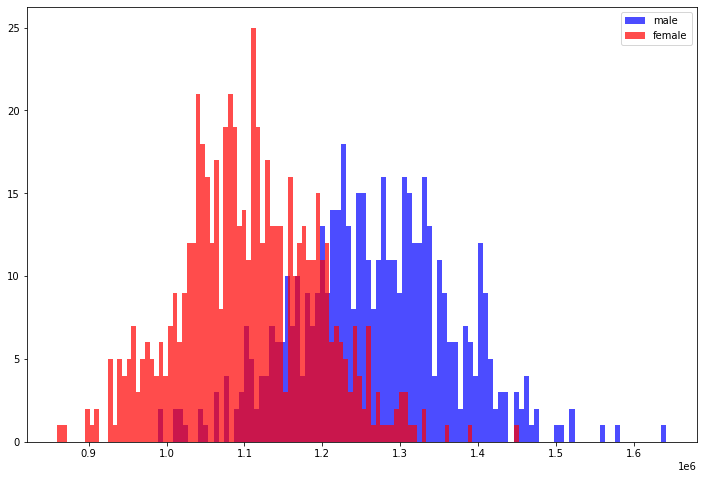

In [89]:
plt.figure(figsize=(12,8))
kwargs = dict(alpha=0.7, bins=100)
plt.hist(male_vols, color='b', label='male', **kwargs)
plt.hist(fem_vols, color='r', label='female', **kwargs)
plt.legend();

### VAE3b32ch16f - normalized data

In [59]:
def vol_distrib(model, loader, vae=False, thresh=0.01):
    with torch.no_grad():
        restruct = None
        labels = []
        model.eval()
        
        for i, (x, y) in enumerate(loader):
            x = model(x.cuda())
            if vae:
                x = x[-1]
                
            if i == 0:
                restruct = x.cpu().numpy()
                labels = y.numpy()
            else:
                restruct = np.vstack([restruct, x.cpu().numpy()])
                labels = np.concatenate([labels, y])
                
                
    vols = np.sum(restruct.reshape((restruct.shape[0], -1)) > thresh, axis=1)
    df = pd.DataFrame({'sex': labels, 'vols': vols})
    
    male_vols = df[df.sex == 1].vols.to_numpy()
    fem_vols = df[df.sex == 0].vols.to_numpy()
    
    plt.figure(figsize=(12,8))
    kwargs = dict(alpha=0.7, bins=100)
    plt.hist(male_vols, color='b', label='male', **kwargs)
    plt.hist(fem_vols, color='r', label='female', **kwargs)
    plt.legend();
    return vols

In [56]:
norm = transforms.Normalize(mean=267.57535, std=350.7396)
ds = TensorDataset(norm(torch.Tensor(tensors[:, None])), torch.Tensor(labels))
loader = DataLoader(ds, batch_size=64)
ds.tensors[0].min()

tensor(-0.7629)

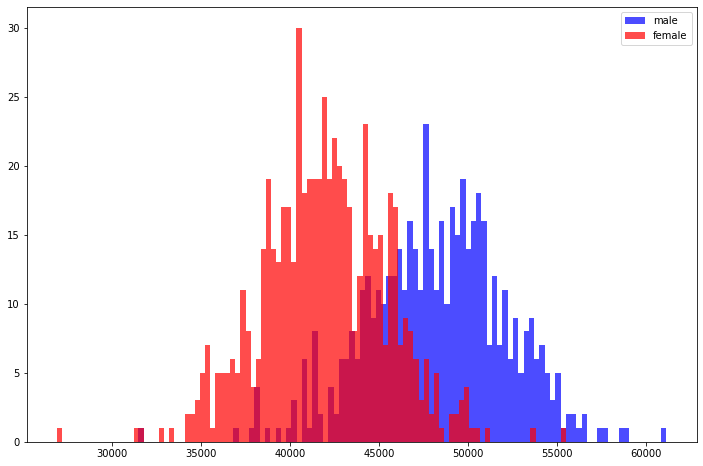

In [90]:
model = VAE3b32ch16f().cuda()
model.load_state_dict(torch.load("saves/vae_exp3/vae3b32ch16f_crit_32", map_location='cpu'))
vols1 = vol_distrib(model, loader, vae=True)

### VAE3b32ch16f with hyperparams

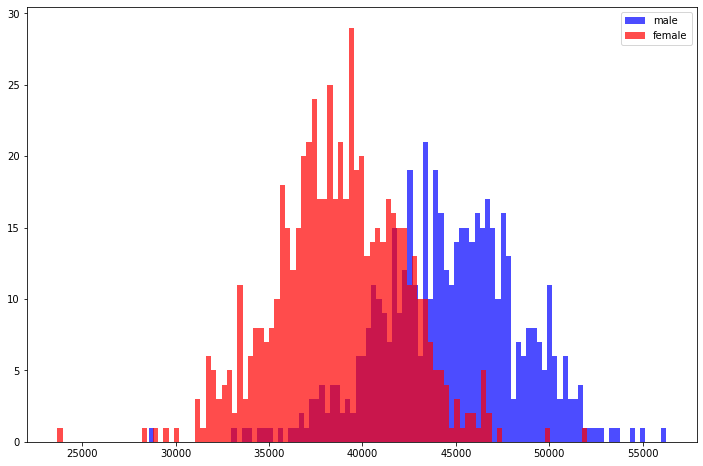

In [91]:
model = VAE3b32ch16f().cuda()
model.load_state_dict(torch.load("saves/vae_exp4/vae3b32ch16f_crit_87", map_location='cpu'))
vols2 = vol_distrib(model, loader, vae=True)

### AE3b32ch16f - normalized data

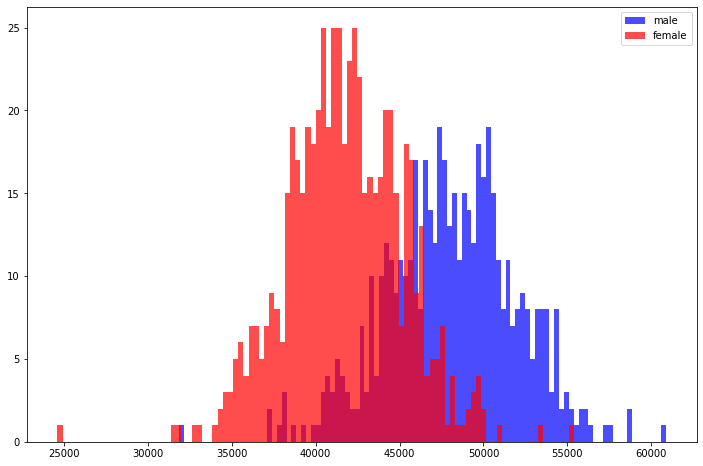

In [92]:
model = AE3b32ch16f().cuda()
model.load_state_dict(torch.load("saves/ae_exp3.5norm/AE3b32ch32f_crit_41", map_location='cpu'))
vols3 = vol_distrib(model, loader)

In [94]:
vols0tr = MinMaxScaler(feature_range=(0, 1)).fit_transform(vols0.reshape(-1, 1))
vols2tr = MinMaxScaler(feature_range=(0, 1)).fit_transform(vols2.reshape(-1, 1))
vols3tr = MinMaxScaler(feature_range=(0, 1)).fit_transform(vols3.reshape(-1, 1))

In [95]:
vols0tr = vols0tr.reshape(-1)
vols2tr = vols2tr.reshape(-1)
vols3tr = vols3tr.reshape(-1)

In [96]:
print("baseline - vae (0.5 acc):    ", scipy.stats.ttest_ind(vols0tr, vols2tr, equal_var=False).pvalue)
print("baseline - ae (0.9 acc):     ", scipy.stats.ttest_ind(vols0tr, vols3tr, equal_var=False).pvalue)
print("ae (0.9 acc) - vae (0.5 acc):", scipy.stats.ttest_ind(vols2tr, vols3tr, equal_var=False).pvalue)

baseline - vae (0.5 acc):     9.702971384580057e-93
baseline - ae (0.9 acc):      9.63530361604037e-106
ae (0.9 acc) - vae (0.5 acc): 0.26954235136068877
